In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import warnings
%matplotlib inline
warnings.filterwarnings("ignore")
df=pd.read_csv("heart.csv")

In [2]:
df.shape

(303, 14)

In [3]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
age         303 non-null int64
sex         303 non-null int64
cp          303 non-null int64
trestbps    303 non-null int64
chol        303 non-null int64
fbs         303 non-null int64
restecg     303 non-null int64
thalach     303 non-null int64
exang       303 non-null int64
oldpeak     303 non-null float64
slope       303 non-null int64
ca          303 non-null int64
thal        303 non-null int64
target      303 non-null int64
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


## Feature Selection

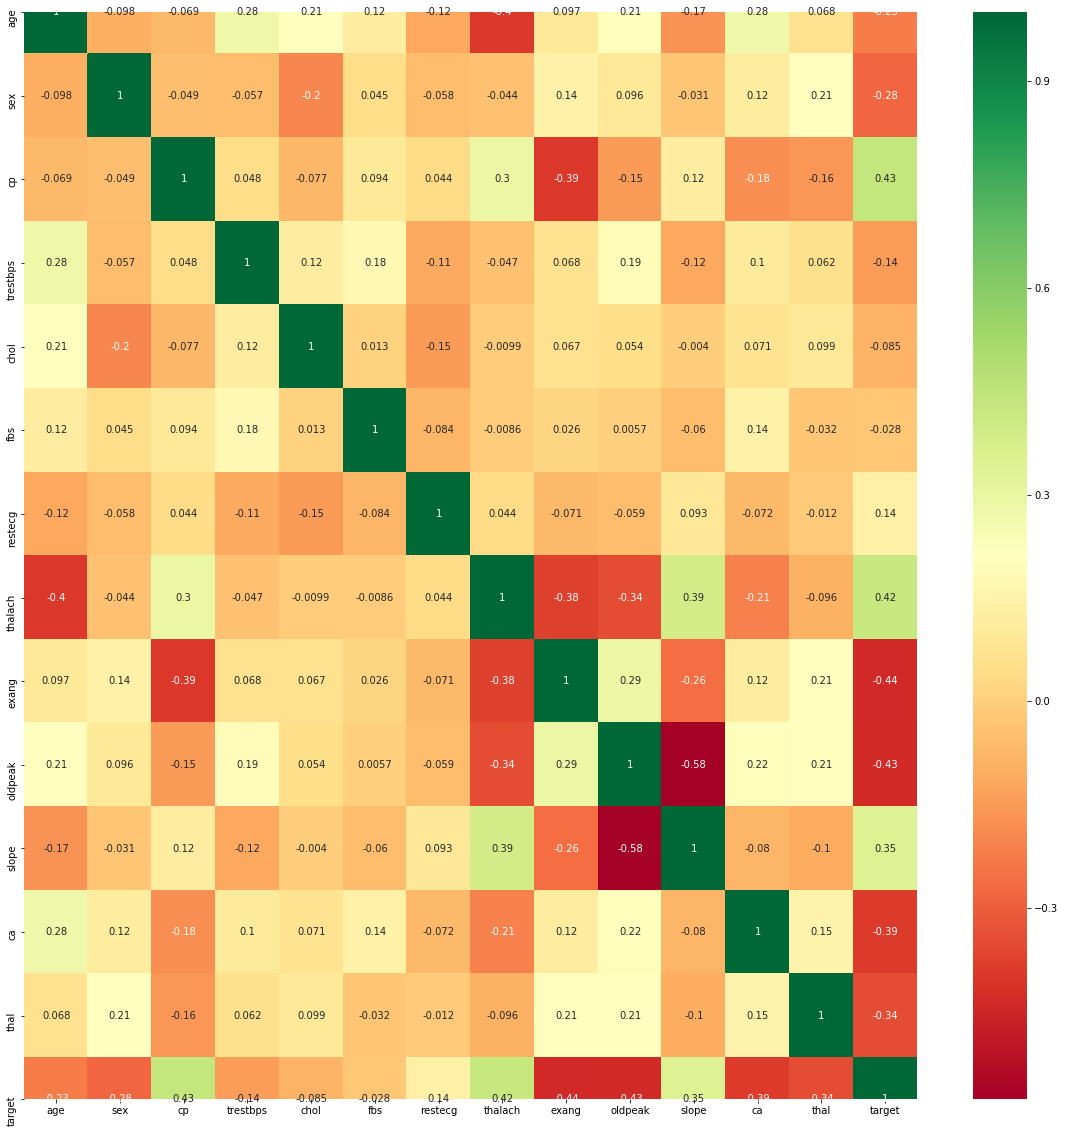

In [5]:
corrmat=df.corr()
top_corr_features=corrmat.index
plt.figure(figsize=(20, 20))
g=sns.heatmap(df[top_corr_features].corr(), annot=True, cmap='RdYlGn')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001B597853D48>,
      dtype=object)

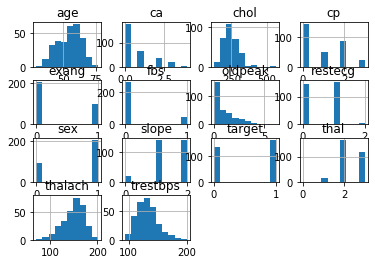

In [6]:
df.hist()

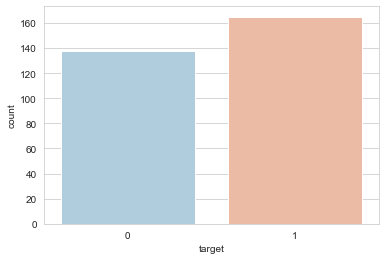

In [7]:
sns.set_style("whitegrid")
sns.countplot(x='target', data=df, palette='RdBu_r')

In [8]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [9]:
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
sc

StandardScaler(copy=True, with_mean=True, with_std=True)

In [10]:
X=df.drop(['target'], axis=1)
y=df.target
X.shape, y.shape

((303, 13), (303,))

In [11]:
X=sc.fit_transform(X)
X[:2]

array([[ 0.9521966 ,  0.68100522,  1.97312292,  0.76395577, -0.25633371,
         2.394438  , -1.00583187,  0.01544279, -0.69663055,  1.08733806,
        -2.27457861, -0.71442887, -2.14887271],
       [-1.91531289,  0.68100522,  1.00257707, -0.09273778,  0.07219949,
        -0.41763453,  0.89896224,  1.63347147, -0.69663055,  2.12257273,
        -2.27457861, -0.71442887, -0.51292188]])

In [12]:
from xgboost import XGBClassifier
xgb=XGBClassifier()
xgb

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [13]:
from sklearn.model_selection import cross_val_score
knn_score=[]

for k in range(1, 21):
    knn=KNeighborsClassifier(n_neighbors=k)
    score=cross_val_score(knn, X, y, cv=10)
    knn_score.append(score.mean())

Text(0.5, 1.0, 'K Neighbors Classifier scores for different K Values')

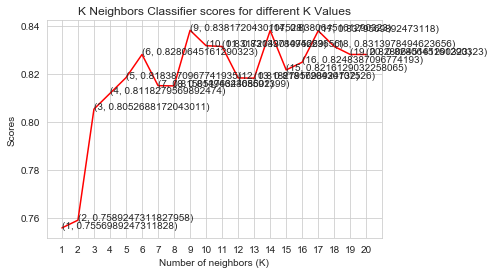

In [14]:
plt.plot([k for k in range(1, 21)], knn_score, color='red')

for i in range(1, 21):
    plt.text(i, knn_score[i-1], (i, knn_score[i-1]))
    
plt.xticks([i for i in range(1, 21)])
plt.xlabel("Number of neighbors (K)")
plt.ylabel("Scores")
plt.title("K Neighbors Classifier scores for different K Values")

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, random_state=100)

In [16]:
knn=KNeighborsClassifier(n_neighbors=9)
score=cross_val_score(knn, X_train, y_train, cv=20)
score.mean()

0.8221153846153847

In [17]:
score=cross_val_score(knn, X_test, y_test, cv=20)
score.mean()

0.85

In [18]:
y_pred=knn.fit(X_train, y_train).predict(X_test)
y_pred[:10], y_test[:10]

(array([1, 0, 0, 1, 1, 0, 0, 0, 1, 1], dtype=int64),
 69     1
 300    0
 220    0
 134    1
 7      1
 291    0
 97     1
 242    0
 18     1
 283    0
 Name: target, dtype: int64)

In [19]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
print("ACCURACY SCORE: {}%".format(np.round((accuracy_score(y_pred, y_test)*100), 4)))
print("Confusion Matrics:\n {}\n".format(confusion_matrix(y_pred, y_test)))
print("Classificatio  Report:\n {}".format(classification_report(y_pred, y_test)))

ACCURACY SCORE: 85.2459%
Confusion Matrics:
 [[27  3]
 [ 6 25]]

Classificatio  Report:
               precision    recall  f1-score   support

           0       0.82      0.90      0.86        30
           1       0.89      0.81      0.85        31

    accuracy                           0.85        61
   macro avg       0.86      0.85      0.85        61
weighted avg       0.86      0.85      0.85        61



In [20]:
score=cross_val_score(xgb, X_train, y_train,cv=10)
score.mean()

0.7978333333333334

In [21]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
r=np.arange(2, 20)
param_grid={
    
    'learning_rate': [0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
    'max_depth': r,
    'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
    'min_child_weight': [1, 2, 3 , 4, 5, 6, 7, 8, 9, 10],
    'colsample_bytree': [0.3, 0.4, 0.5, 0.6, 0.7]
    
}

In [22]:
grid=RandomizedSearchCV(estimator=XGBClassifier(), param_distributions=param_grid, n_iter=10, cv=5, scoring='roc_auc', verbose=5)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] min_child_weight=1, max_depth=14, learning_rate=0.3, gamma=0.3, colsample_bytree=0.7 
[CV]  min_child_weight=1, max_depth=14, learning_rate=0.3, gamma=0.3, colsample_bytree=0.7, score=0.850, total=   0.0s
[CV] min_child_weight=1, max_depth=14, learning_rate=0.3, gamma=0.3, colsample_bytree=0.7 
[CV]  min_child_weight=1, max_depth=14, learning_rate=0.3, gamma=0.3, colsample_bytree=0.7, score=0.888, total=   0.0s
[CV] min_child_weight=1, max_depth=14, learning_rate=0.3, gamma=0.3, colsample_bytree=0.7 
[CV]  min_child_weight=1, max_depth=14, learning_rate=0.3, gamma=0.3, colsample_bytree=0.7, score=0.926, total=   0.1s
[CV] min_child_weight=1, max_depth=14, learning_rate=0.3, gamma=0.3, colsample_bytree=0.7 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s


[CV]  min_child_weight=1, max_depth=14, learning_rate=0.3, gamma=0.3, colsample_bytree=0.7, score=0.908, total=   0.1s
[CV] min_child_weight=1, max_depth=14, learning_rate=0.3, gamma=0.3, colsample_bytree=0.7 
[CV]  min_child_weight=1, max_depth=14, learning_rate=0.3, gamma=0.3, colsample_bytree=0.7, score=0.954, total=   0.0s
[CV] min_child_weight=4, max_depth=12, learning_rate=0.05, gamma=0.2, colsample_bytree=0.6 
[CV]  min_child_weight=4, max_depth=12, learning_rate=0.05, gamma=0.2, colsample_bytree=0.6, score=0.879, total=   0.0s
[CV] min_child_weight=4, max_depth=12, learning_rate=0.05, gamma=0.2, colsample_bytree=0.6 
[CV]  min_child_weight=4, max_depth=12, learning_rate=0.05, gamma=0.2, colsample_bytree=0.6, score=0.905, total=   0.0s
[CV] min_child_weight=4, max_depth=12, learning_rate=0.05, gamma=0.2, colsample_bytree=0.6 
[CV]  min_child_weight=4, max_depth=12, learning_rate=0.05, gamma=0.2, colsample_bytree=0.6, score=0.905, total=   0.0s
[CV] min_child_weight=4, max_depth=

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


[CV] min_child_weight=7, max_depth=13, learning_rate=0.15, gamma=0.4, colsample_bytree=0.3 
[CV]  min_child_weight=7, max_depth=13, learning_rate=0.15, gamma=0.4, colsample_bytree=0.3, score=0.881, total=   0.0s
[CV] min_child_weight=7, max_depth=13, learning_rate=0.15, gamma=0.4, colsample_bytree=0.3 
[CV]  min_child_weight=7, max_depth=13, learning_rate=0.15, gamma=0.4, colsample_bytree=0.3, score=0.912, total=   0.0s
[CV] min_child_weight=7, max_depth=13, learning_rate=0.15, gamma=0.4, colsample_bytree=0.3 
[CV]  min_child_weight=7, max_depth=13, learning_rate=0.15, gamma=0.4, colsample_bytree=0.3, score=0.887, total=   0.0s
[CV] min_child_weight=7, max_depth=13, learning_rate=0.15, gamma=0.4, colsample_bytree=0.3 
[CV]  min_child_weight=7, max_depth=13, learning_rate=0.15, gamma=0.4, colsample_bytree=0.3, score=0.933, total=   0.0s
[CV] min_child_weight=7, max_depth=13, learning_rate=0.15, gamma=0.4, colsample_bytree=0.3 
[CV]  min_child_weight=7, max_depth=13, learning_rate=0.15, 

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.6s finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1, sc...
                   param_distributions={'colsample_bytree': [0.3, 0.4, 0.5, 0.6,
                                                             0.7],
                             

In [23]:
print("Best Estimator is {} \nBest Score is {}\nBest Parameters: {}".format(
        grid.best_estimator_, grid.best_score_, grid.best_params_
        )
    )

Best Estimator is XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0.4,
              learning_rate=0.15, max_delta_step=0, max_depth=13,
              min_child_weight=7, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1) 
Best Score is 0.9130007558578986
Best Parameters: {'min_child_weight': 7, 'max_depth': 13, 'learning_rate': 0.15, 'gamma': 0.4, 'colsample_bytree': 0.3}


In [24]:
xbg=grid.best_estimator_
# xgb=XGBClassifier(colsample_bytree=0.3, gamma=0.4, learning_rate=0.2, max_depth=13, min_child_weight=10)

In [25]:
xgb.fit(X_train, y_train)
xgb.score(X_test, y_test)
#colsample_bytree=0.3, gamma=0.4, learning_rate=0.2, max_depth=13, min_child_weight=10, score=0.966 #==>0.966

0.8360655737704918

In [26]:
y_pred=xgb.fit(X_train, y_train).predict(X_test)
y_pred[:10], y_test[:10]

(array([1, 0, 0, 1, 1, 0, 0, 0, 1, 1], dtype=int64),
 69     1
 300    0
 220    0
 134    1
 7      1
 291    0
 97     1
 242    0
 18     1
 283    0
 Name: target, dtype: int64)

In [27]:
score=cross_val_score(xgb, X_train, y_train, cv=10)
score.mean()

0.7978333333333334

In [28]:
print("ACCURACY SCORE: {}%".format(np.round((accuracy_score(y_pred, y_test)*100), 4)))
print("Confusion Matrics:\n {}\n".format(confusion_matrix(y_pred, y_test)))
print("Classificatio  Report:\n {}".format(classification_report(y_pred, y_test)))

ACCURACY SCORE: 83.6066%
Confusion Matrics:
 [[25  2]
 [ 8 26]]

Classificatio  Report:
               precision    recall  f1-score   support

           0       0.76      0.93      0.83        27
           1       0.93      0.76      0.84        34

    accuracy                           0.84        61
   macro avg       0.84      0.85      0.84        61
weighted avg       0.85      0.84      0.84        61

